# Metapath2Vec with StellarGraph

- dataset: local Cora


In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks, regularizers

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

### graph setting

In [2]:
edges = pd.read_csv('../datasets/blogcat/edges.csv', header=None)
group_edges = pd.read_csv('../datasets/blogcat/group-edges.csv', header=None)
group = pd.read_csv('../datasets/blogcat/groups.csv', header=None)
nodes = pd.read_csv('../datasets/blogcat/nodes.csv', header=None)

edges.columns = ['source', 'target']
group_edges.columns = ['source', 'target']

def u(users):
    return "u" + users.astype(str)

def g(groups):
    return "g" + groups.astype(str)

# nodes:
user_node_ids = u(nodes)
group_ids = g(group)

# node IDs in each edge:
edges = u(edges)
group_edges["source"] = u(group_edges["source"])
group_edges["target"] = g(group_edges["target"])

# arrange the DataFrame indices appropriately: nodes use their node IDs, which have
# been made distinct above, and the group edges have IDs after the other edges
user_node_ids.set_index(0, inplace=True)
group_ids.set_index(0, inplace=True)

start = len(edges)
group_edges.index = range(start, start + len(group_edges))

g = sg.StellarGraph(nodes={'user': user_node_ids, 'group': group_ids},
                   edges={'friend': edges, 'belongs': group_edges})

print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 348459

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [333983]
    user-belongs->group: [14476]


### explore neighborhoods

In [3]:
metapaths = [
    ["user", "group", "user"],
#     ["user", "group", "user", "user"],
    ["user", "user"],
]

In [4]:
%%time
from stellargraph.data import UniformRandomMetaPathWalk
# tatke long time

# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(g.nodes()),  # root nodes
    length=10,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

Wall time: 3h 40min 57s


In [5]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, iter=1)

In [8]:
node_ids = model.wv.index2word  # list of node IDs
x = (model.wv.vectors)
y = [g.node_type(node_id) for node_id in node_ids]

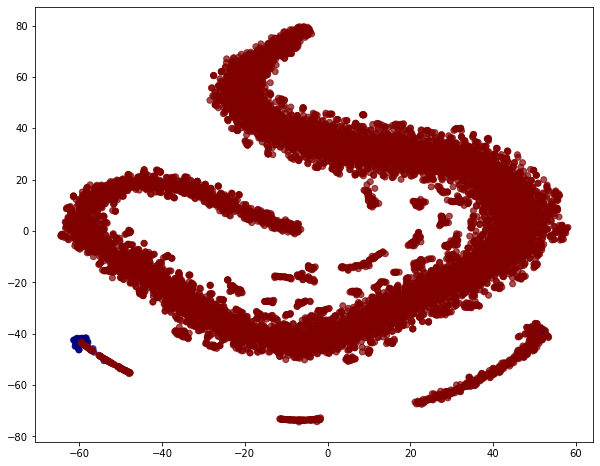

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(x)

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(y))}
node_colours = [label_map[target] for target in y]

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)

print('fl-micro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_micro', cv=10)), 3))
print('f1-macro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_macro', cv=10)), 3))


fl-micro: 0.993
f1-macro: 0.79


In [11]:
lbe = preprocessing.LabelBinarizer()
targets = lbe.fit_transform(y)

# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(targets.shape[0])
train_node_idx = shuffled_idx[:500]
test_node_idx = shuffled_idx[500:]

training_labels = targets.copy()
training_labels[test_node_idx] = 0

d = x.shape[1] // 2

predictions = np.dot(np.exp(np.dot(x[:, :d], x[:, d:].transpose())), training_labels)

np.mean(np.argmax(predictions[test_node_idx], 1) == np.argmax(targets[test_node_idx], 1))


1.0